In [1]:
# Synthetic Experiment 2 for fairness 

# Load all necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import generate_data, generate_a_hat, generate_y_hat, calc_gen_bounds, calculate_bias_metrics, calc_base_rates
from updated_balancers import BinaryBalancer
from tqdm import tqdm
sns.set_theme()

In [6]:
# Set the experiment
exp = 2

# Generate data
n = 10000
e1 = 1.5
e2 = 1.5
b = 0.05
group = 1
X, a, y  = generate_data(n,e1,e2,b,group,exp)

# Calculate base rates
r,s,v,w = calc_base_rates(y,a)
min_rate = min(r,s,v,w)
print('min rate = ', min_rate)

# Generate y_hat using random coefficients
k = 1000
mu_c = np.array([1,1,1])
var_c = np.array([[0.1,0,0],[0,0.1,0],[0,0,0.1]])
coeffs = np.random.multivariate_normal(mu_c,var_c,k).T
y_prob, y_hat_mat = generate_y_hat(X,coeffs,exp)

min rate =  0.1757


In [7]:
# Generate a_hat
U_errors = [0.05,0.15]
diff_bound_tpr = []
diff_bound_fpr = []

for u in U_errors:
    a_hat = generate_a_hat(X[:,2],b,u)
    a_error = np.sum(a_hat != a)/a_hat.shape[0]
    bias_tpr_list = []
    bias_fpr_list = []
    u_bound_tpr = []
    u_bound_fpr = []
    print('a_hat_error = ', a_error)

    for i in tqdm(range(k)): 
        y_hat = y_hat_mat[:,i]

        # bias using true values of a
        balancer = BinaryBalancer(y=y, a=a, y_=y_hat)
        alpha, beta, tau, phi = calculate_bias_metrics(balancer)
        # print('bias = ', np.abs(alpha-beta))
        bias_tpr = np.abs(alpha - beta)
        bias_tpr_list.append(bias_tpr)
        bias_fpr = np.abs(tau-phi)
        bias_fpr_list.append(bias_fpr)

        # bias estimate using a_hat
        balancer_h = BinaryBalancer(y=y, a=a_hat, y_=y_hat)
        alpha_h, beta_h, tau_h , phi_h = calculate_bias_metrics(balancer_h)

        # Computing the upper bound and lower bounds under the assumption
        ub1_t, ub2_t = calc_gen_bounds(alpha_h,beta_h,a_error,r,s)
        ub1_f, ub2_f = calc_gen_bounds(tau_h,phi_h,a_error,v,w)
        u_bound_tpr.append(max(np.abs(ub1_t),np.abs(ub2_t)))
        u_bound_fpr.append(max(np.abs(ub1_f),np.abs(ub2_f)))

    diff_bound_tpr.append(np.array(u_bound_tpr) - np.array(bias_tpr_list))
    diff_bound_fpr.append(np.array(u_bound_fpr) - np.array(bias_fpr_list))

a_hat_error =  0.0185


100%|██████████| 1000/1000 [00:22<00:00, 44.22it/s]


a_hat_error =  0.058


100%|██████████| 1000/1000 [00:22<00:00, 44.33it/s]


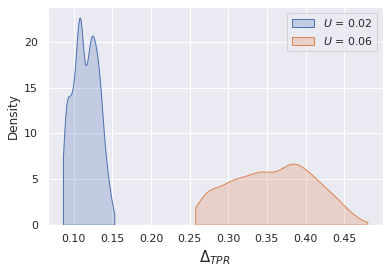

In [10]:
# Generate KDE Plots
sns.kdeplot(diff_bound_tpr[0], shade = True, label = r'$U$ = 0.02',cut = 0)
# sns.kdeplot(diff_bound[1], shade = True, label = r'$U$ = 0.10',cut = 0)
sns.kdeplot(diff_bound_tpr[1], shade = True, label = r'$U$ = 0.06',cut = 0)
# sns.kdeplot(diff_bound[3], shade = True, label = r'$U$ = 0.20',cut = 0)
plt.legend()
plt.xlabel(r'$\Delta_{TPR}$', fontsize=15)
plt.savefig('Figures/newExp2/bias_tpr_bound',bbox_inches="tight")

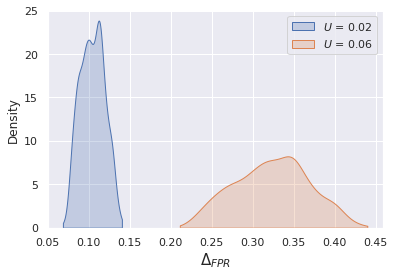

In [11]:
# Generate KDE Plots
sns.kdeplot(diff_bound_fpr[0], shade = True, label = r'$U$ = 0.02',cut = 0)
# sns.kdeplot(diff_bound[1], shade = True, label = r'$U$ = 0.10',cut = 0)
sns.kdeplot(diff_bound_fpr[1], shade = True, label = r'$U$ = 0.06',cut = 0)
# sns.kdeplot(diff_bound[3], shade = True, label = r'$U$ = 0.20',cut = 0)
plt.legend()
plt.xlabel(r'$\Delta_{FPR}$', fontsize=15)
plt.savefig('Figures/newExp2/bias_fpr_bound',bbox_inches="tight")

In [12]:
# bias control
# Sample second dataset which will be used to generate fair classifiers 
X_2, a_2, y_2  = generate_data(n,e1,e2,b,group,exp)
y_prob_2, y_hat_mat_2 = generate_y_hat(X_2,coeffs,exp)

In [13]:
# Generate a_hat
from utils import eo_postprocess

U_errors = [0.05]
diff_bound_tpr_pre = []
diff_bound_fpr_pre = []
diff_bound_tpr_post = []
diff_bound_fpr_post = []

for u in U_errors:
    a_hat = generate_a_hat(X[:,2],b,u)
    a_hat_2 = generate_a_hat(X_2[:,2],b,u)
    a_error = np.sum(a_hat != a)/a_hat.shape[0]
    bias_tpr_list_pre = []
    bias_fpr_list_pre = []
    bias_tpr_list_post = []
    bias_fpr_list_post = []
    u_bound_tpr_pre = []
    u_bound_fpr_pre = []
    u_bound_tpr_post = []
    u_bound_fpr_post = []
    print('a_hat_error = ', a_error)

    for i in tqdm(range(k)): 
        y_hat = y_hat_mat[:,i]

        # bias using true values of a
        balancer = BinaryBalancer(y=y, a=a, y_=y_hat)
        alpha, beta, tau, phi = calculate_bias_metrics(balancer)
        # print('bias = ', np.abs(alpha-beta))
        bias_tpr = np.abs(alpha - beta)
        bias_tpr_list_pre.append(bias_tpr)
        bias_fpr = np.abs(tau-phi)
        bias_fpr_list_pre.append(bias_fpr)

        # bias estimate using a_hat
        balancer_h = BinaryBalancer(y=y, a=a_hat, y_=y_hat)
        alpha_h, beta_h, tau_h , phi_h = calculate_bias_metrics(balancer_h)

        # Computing the upper bounds before 
        ub1_t, ub2_t = calc_gen_bounds(alpha_h,beta_h,a_error,r,s)
        ub1_f, ub2_f = calc_gen_bounds(tau_h,phi_h,a_error,v,w)
        u_bound_tpr_pre.append(max(np.abs(ub1_t),np.abs(ub2_t)))
        u_bound_fpr_pre.append(max(np.abs(ub1_f),np.abs(ub2_f)))

        # Get fair model using validation set
        y_hat_2 = y_hat_mat_2[:,i]
        fair_yh2, fair_model = eo_postprocess(y,y_hat,a_hat)

        # Use fair model to predict on 
        fair_yh = fair_model.predict(y_hat,a_hat)
        balancer_fair = BinaryBalancer(y=y, a=a_hat, y_=fair_yh)
        alpha_h, beta_h, tau_h , phi_h = calculate_bias_metrics(balancer_fair)

        # Computing the upper bounds after 
        ub1_t, ub2_t = calc_gen_bounds(alpha_h,beta_h,a_error,r,s)
        ub1_f, ub2_f = calc_gen_bounds(tau_h,phi_h,a_error,v,w)
        u_bound_tpr_post.append(max(np.abs(ub1_t),np.abs(ub2_t)))
        u_bound_fpr_post.append(max(np.abs(ub1_f),np.abs(ub2_f)))

    diff_bound_tpr_pre.append(np.array(u_bound_tpr_pre))
    diff_bound_fpr_pre.append(np.array(u_bound_fpr_pre))
    diff_bound_tpr_post.append(np.array(u_bound_tpr_post))
    diff_bound_fpr_post.append(np.array(u_bound_fpr_post))

a_hat_error =  0.0185


100%|██████████| 1000/1000 [01:00<00:00, 16.46it/s]


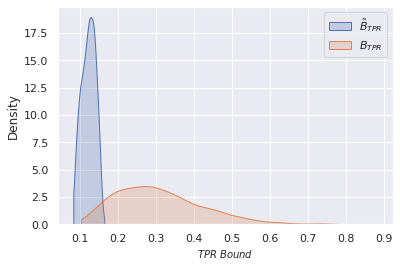

In [31]:
# Generate KDE Plots
sns.kdeplot(diff_bound_tpr_post[0], shade = True, label = r'$\tilde{B}_{TPR}$',cut = 0)
sns.kdeplot(diff_bound_tpr_pre[0], shade = True, label = r'$B_{TPR}$',cut = 0)
# sns.kdeplot(diff_bound[1], shade = True, label = r'$U$ = 0.10',cut = 0)
# sns.kdeplot(diff_bound_tpr_post[0], shade = True, label = r'$After$',cut = 0)
# sns.kdeplot(diff_bound[3], shade = True, label = r'$U$ = 0.20',cut = 0)
plt.legend()
plt.xlabel(r'$TPR\ Bound$', fontsize=10)
plt.savefig('Figures/newExp2/bias_tpr_control',bbox_inches="tight")

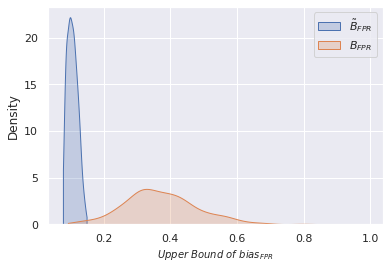

In [30]:
# Generate KDE Plots
sns.kdeplot(diff_bound_fpr_post[0], shade = True, label = r'$\tilde{B}_{FPR}$',cut = 0)
sns.kdeplot(diff_bound_fpr_pre[0], shade = True, label = r'$B_{FPR}$',cut = 0)
# sns.kdeplot(diff_bound_tpr_post[0], shade = True, label = r'$After$',cut = 0)
# sns.kdeplot(diff_bound[3], shade = True, label = r'$U$ = 0.20',cut = 0)
plt.legend()
plt.xlabel(r'$Upper\ Bound\ of\ bias_{FPR}$', fontsize=10)
plt.savefig('Figures/newExp2/bias_fpr_control',bbox_inches="tight")